[saved] table → output/neuron_diff_table/table_layer0_fc1.csv  (rows=4096, cols=49)


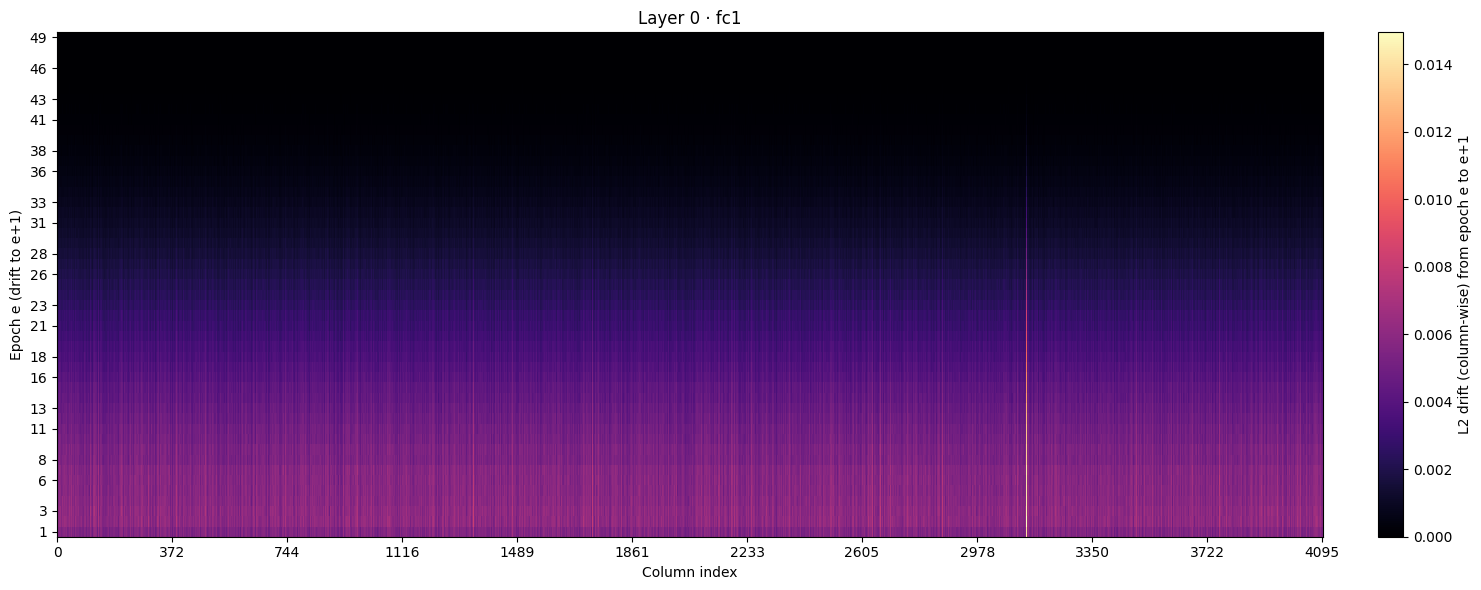

[saved] table → output/neuron_diff_table/table_layer0_fc2.csv  (rows=16384, cols=49)


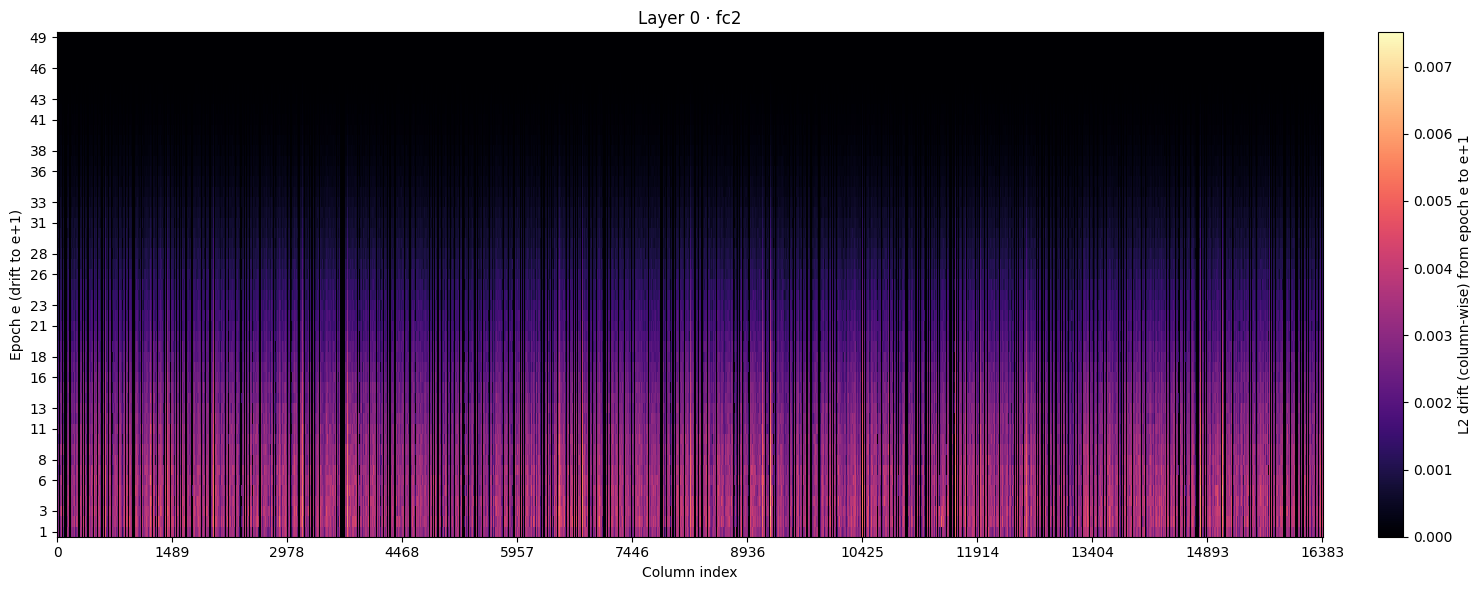

[saved] table → output/neuron_diff_table/table_layer0_final_layer_norm.csv  (rows=4096, cols=49)


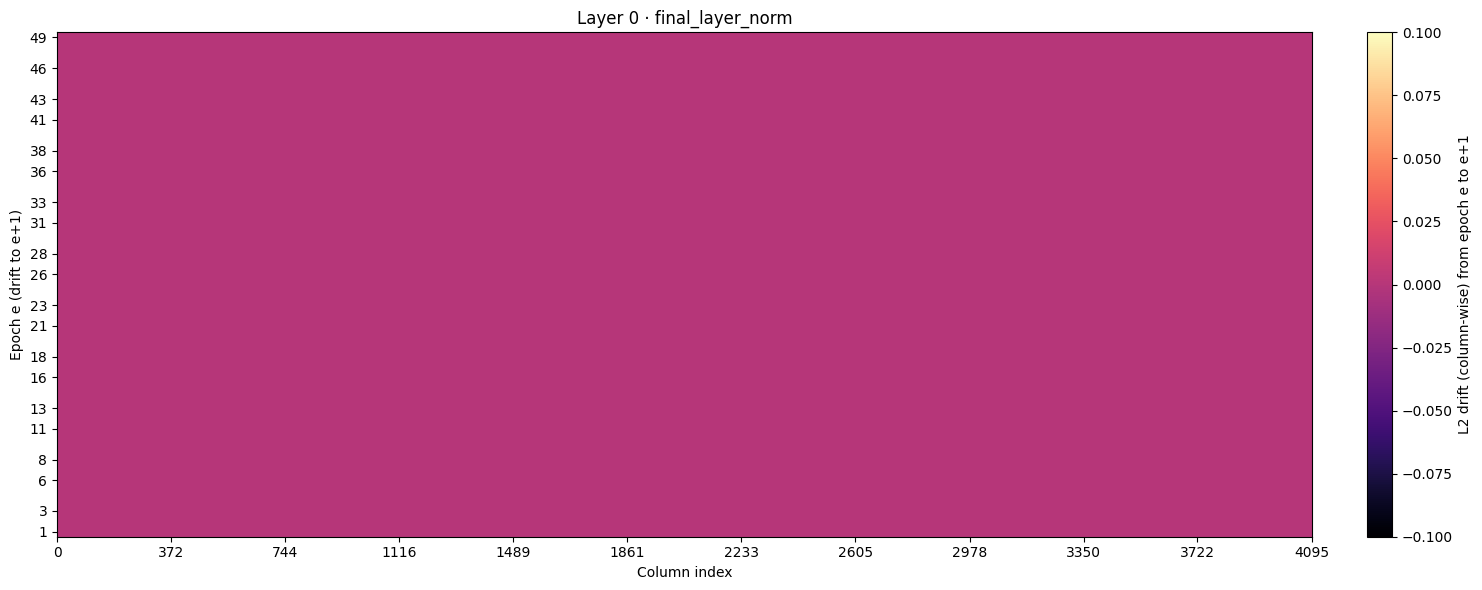

[saved] table → output/neuron_diff_table/table_layer0_k_proj.csv  (rows=4096, cols=49)


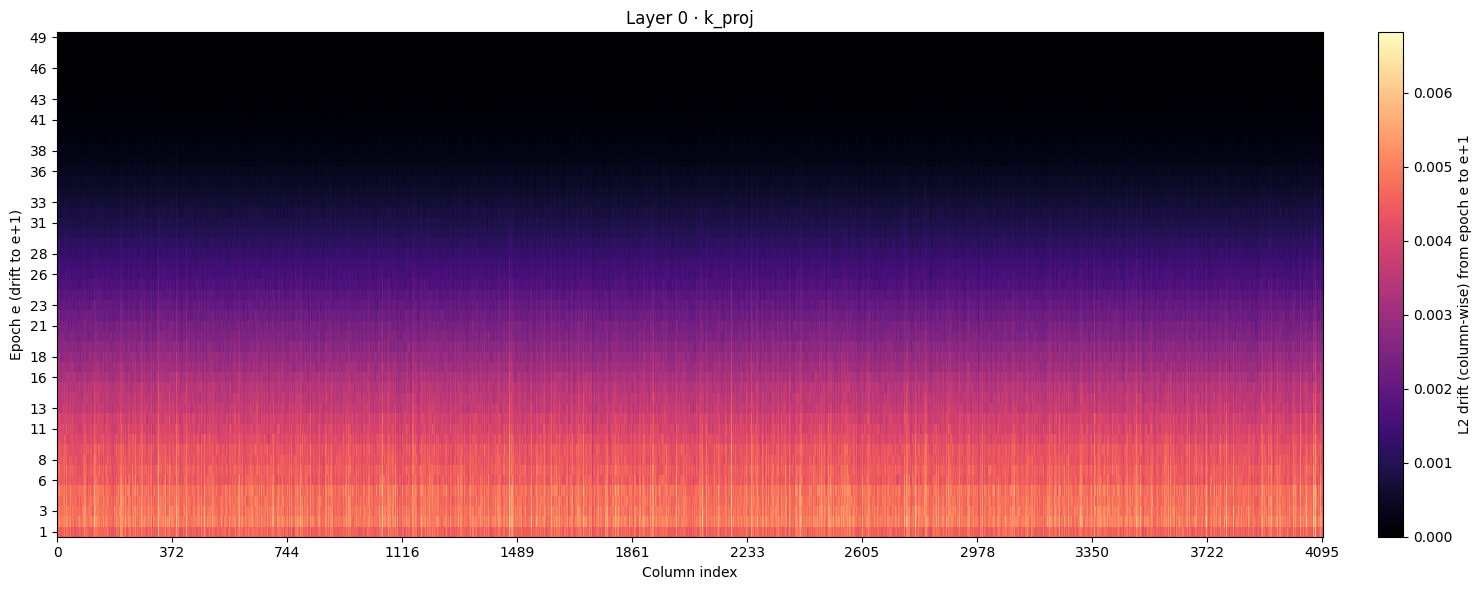

[saved] table → output/neuron_diff_table/table_layer0_out_proj.csv  (rows=4096, cols=49)


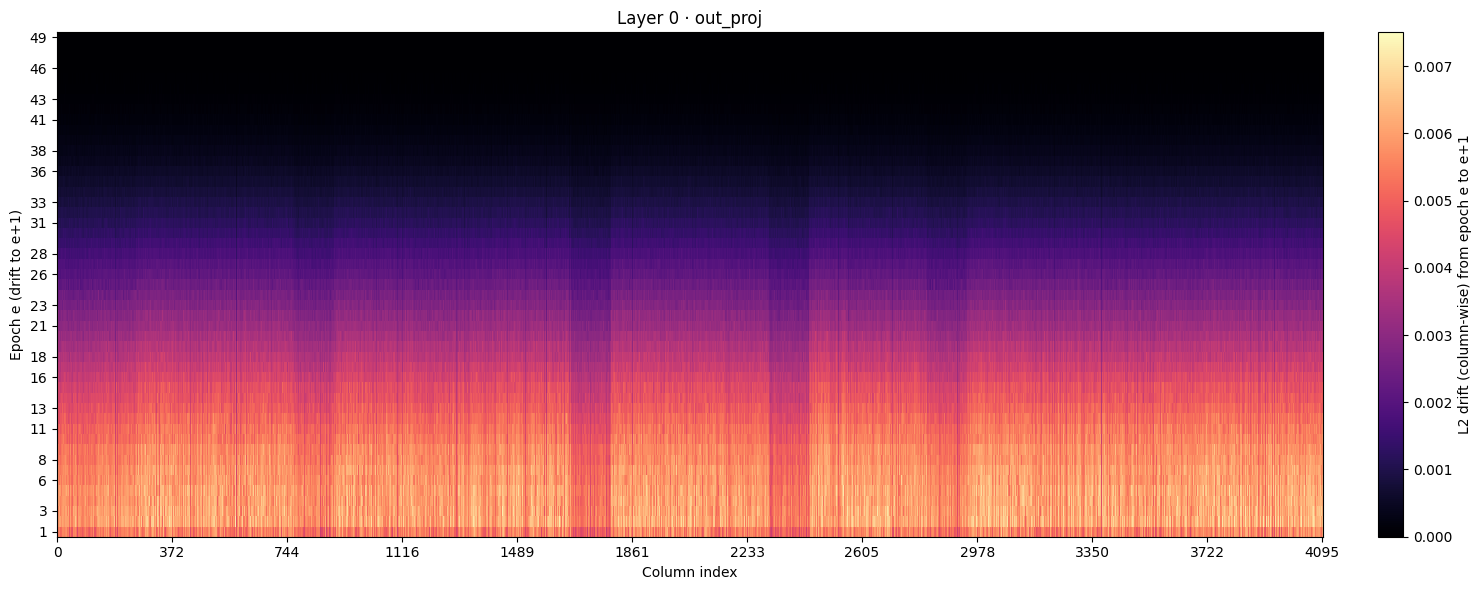

[saved] table → output/neuron_diff_table/table_layer0_q_proj.csv  (rows=4096, cols=49)


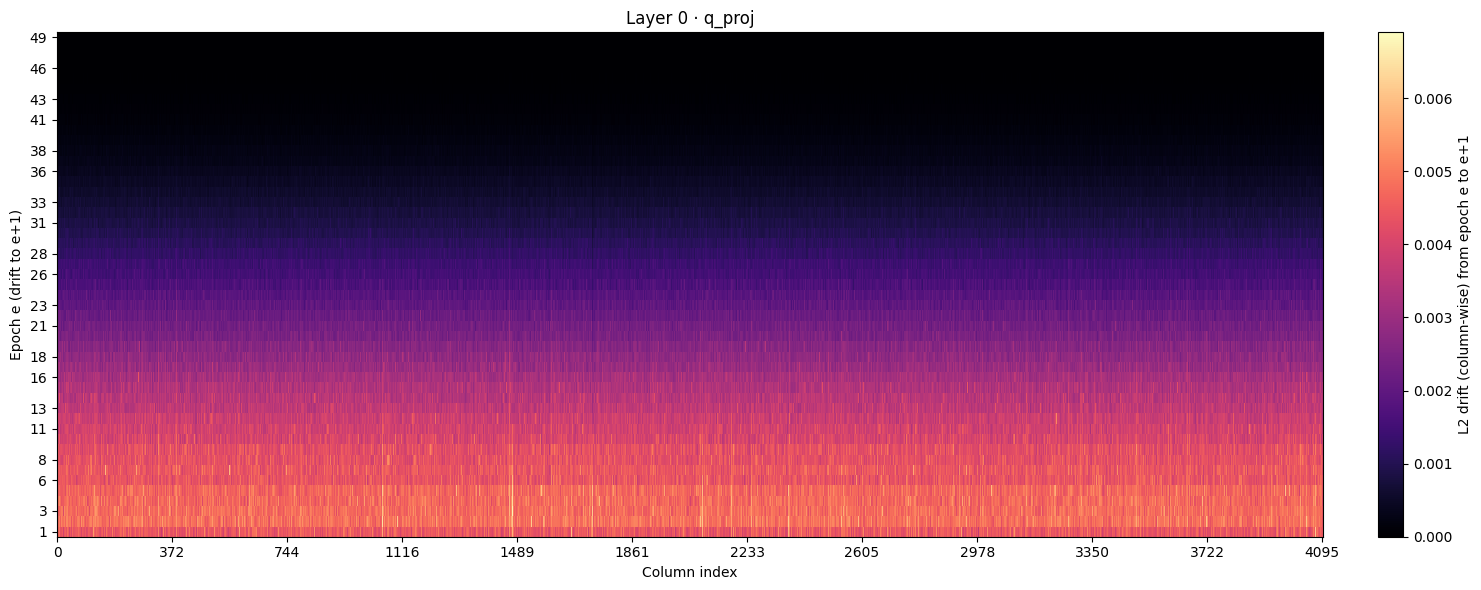

[saved] table → output/neuron_diff_table/table_layer0_self_attn_layer_norm.csv  (rows=4096, cols=49)


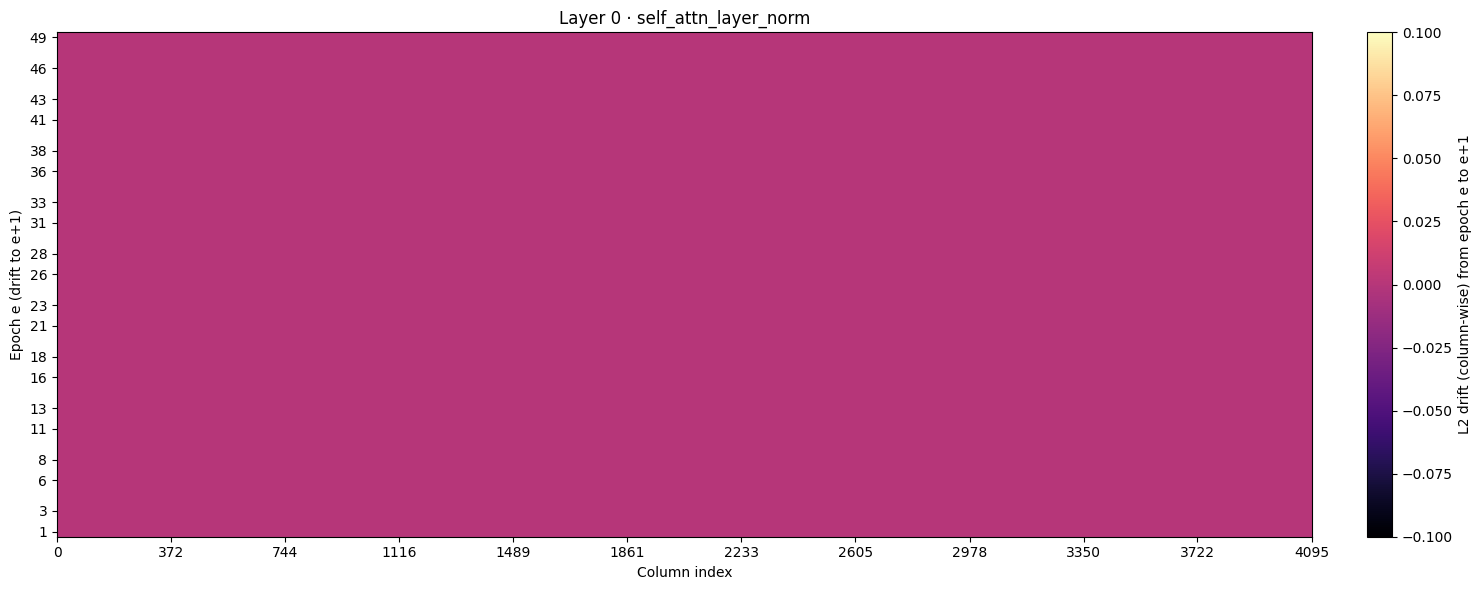

[saved] table → output/neuron_diff_table/table_layer0_v_proj.csv  (rows=4096, cols=49)


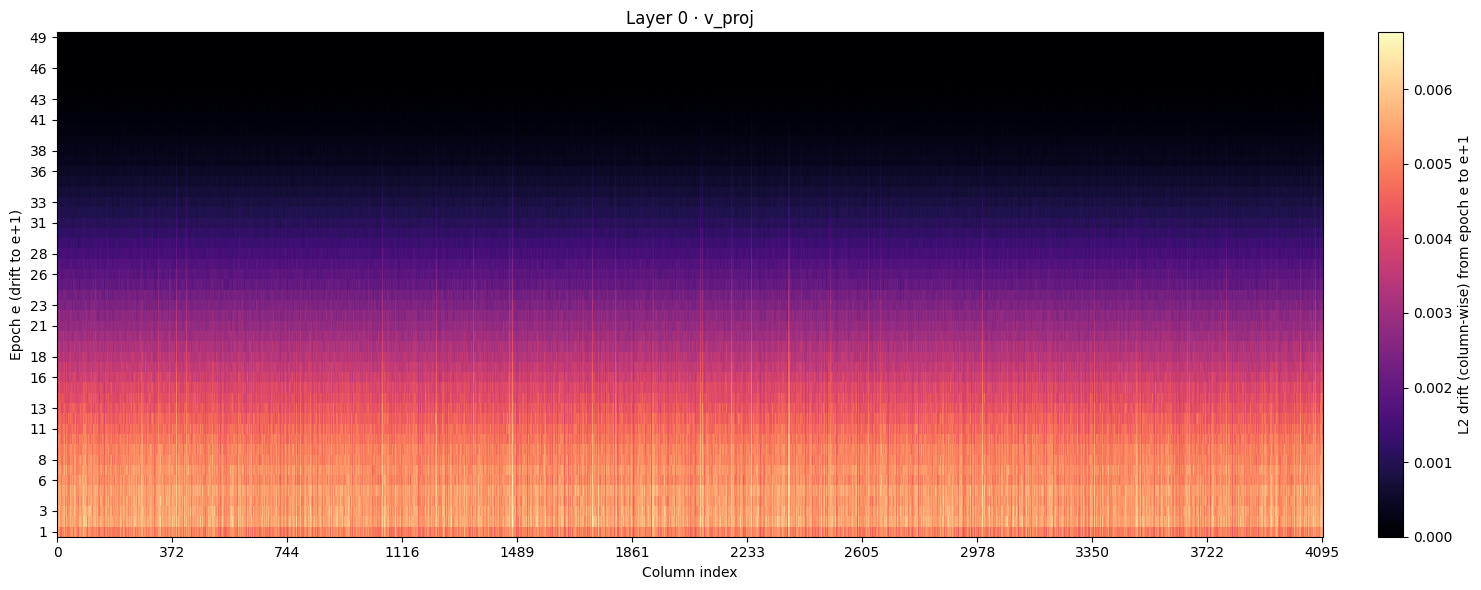

In [14]:
#!/usr/bin/env python3
# plot_drift_heatmaps.py
import argparse, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def build_pivot(df_op: pd.DataFrame) -> tuple[pd.DataFrame, np.ndarray]:
    """
    Return (P, epochs) where P is a pivot table:
      index=row = column index (or LN element id)
      columns = epoch_from (drift from e -> e+1)
      values  = l2_abs_change
    """
    df_op = df_op.copy()
    df_op["epoch_from"] = df_op["epoch_from"].astype(int)
    df_op["index"] = df_op["index"].astype(int)
    P = (df_op.pivot(index="index", columns="epoch_from", values="l2_abs_change")
                .sort_index(axis=0)
                .sort_index(axis=1))
    epochs = P.columns.to_numpy()
    return P, epochs

def autoscale_ticks(ax, values, axis="x", max_ticks=12):
    n = len(values)
    if n <= max_ticks:
        ticks = np.arange(n)
    else:
        ticks = np.linspace(0, n - 1, max_ticks, dtype=int)
        ticks = np.unique(ticks)
    labels = [str(values[i]) for i in ticks]
    if axis == "x":
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels, rotation=0)
    else:
        ax.set_yticks(ticks)
        ax.set_yticklabels(labels)

layer = 0
input_file = "./output/neuron_diff_raw/layer-0.csv"
outdir = 'output/neuron_diff_table'
os.makedirs(outdir, exist_ok=True)
# tables_dir = args.tables_outdir or args.outdir
os.makedirs(outdir, exist_ok=True)

df = pd.read_csv(input_file)
df = df[df["layer"] == layer].copy()
if df.empty:
    raise SystemExit(f"No rows for layer {layer} in {input_file}")

# Limit to requested operators if provided
# if args.ops:
#     ops = [s.strip() for s in args.ops.split(",") if s.strip()]
#     df = df[df["operator"].isin(ops)]
#     if df.empty:
#         raise SystemExit("After filtering by --ops, no data remains.")
# else:
ops = sorted(df["operator"].unique())

# Parse preview size if requested
# preview_rows = preview_cols = None
# if args.preview:
#     try:
#         r, c = args.preview.lower().split("x")
#         preview_rows, preview_cols = int(r), int(c)
#     except Exception:
#         raise SystemExit("--preview must look like '10x8' (ROWSxCOLS)")

for op in ops:
    df_op = df[df["operator"] == op]
    if df_op.empty:
        print(f"[skip] No rows for operator={op}")
        continue

    # Build pivot table and save it
    P, epochs = build_pivot(df_op)
    table_path = os.path.join(outdir, f"table_layer{layer}_{op}.csv")
    P.to_csv(table_path, float_format="%.6g")
    print(f"[saved] table → {table_path}  (rows={P.shape[0]}, cols={P.shape[1]})")

    # # Optional: print a small preview
    # if preview_rows and preview_cols:
    #     print(f"\n# Preview: {op} (first {preview_rows} rows × {preview_cols} cols)")
    #     print(P.iloc[:preview_rows, :preview_cols])

    # Plot heatmap with axes swapped: x = column index, y = epoch
    M = P.to_numpy(dtype=np.float32)
    M_plot = M.T                             # now rows=epochs, cols=column indices
    M_masked = np.ma.masked_invalid(M_plot)

    fig = plt.figure(figsize=(15, 6))
    ax = plt.gca()

    # cmap = plt.get_cmap("gray_r").copy()     # larger = darker
    # cmap.set_bad("white")                    # NaNs show as white
    # im = ax.imshow(M_masked, origin="lower", aspect="auto", cmap=cmap)
    
    cmap="magma"
    im = plt.imshow(M_masked, aspect="auto", interpolation="nearest", cmap=cmap, origin="lower",
                    vmin=M_masked.min(), vmax=M_masked.max())

    # cbar = plt.colorbar(im)
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label("L2 drift (column-wise) from epoch e to e+1")

    # x-axis = column index (use the pivot's row index labels)
    col_ids = P.index.to_numpy()
    # y-axis = epochs (pivot's column labels)
    epochs = P.columns.to_numpy()

    ax.set_xlabel("Column index")
    ax.set_ylabel("Epoch e (drift to e+1)")

    autoscale_ticks(ax, col_ids, axis="x", max_ticks=12)
    autoscale_ticks(ax, epochs,  axis="y", max_ticks=20)

    title = f"Layer {layer} · {op}"
    ax.set_title(title)

    plt.tight_layout()
    plt.show()
    # plt.close(fig)

### L2 Drift Distribution

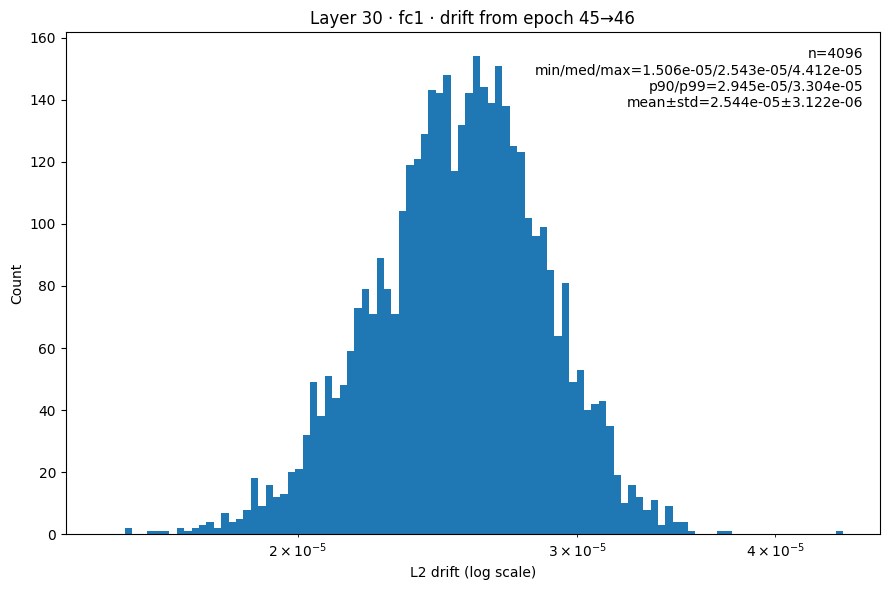

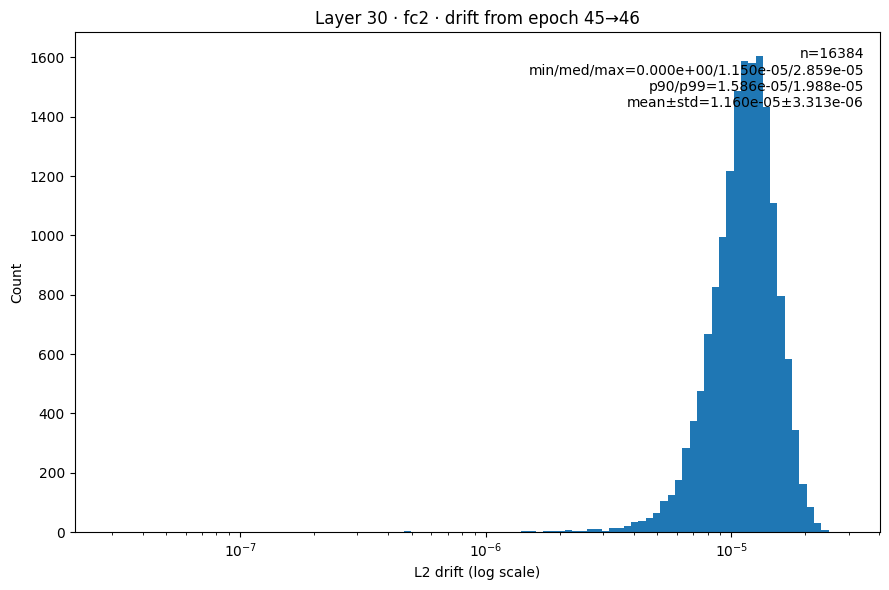

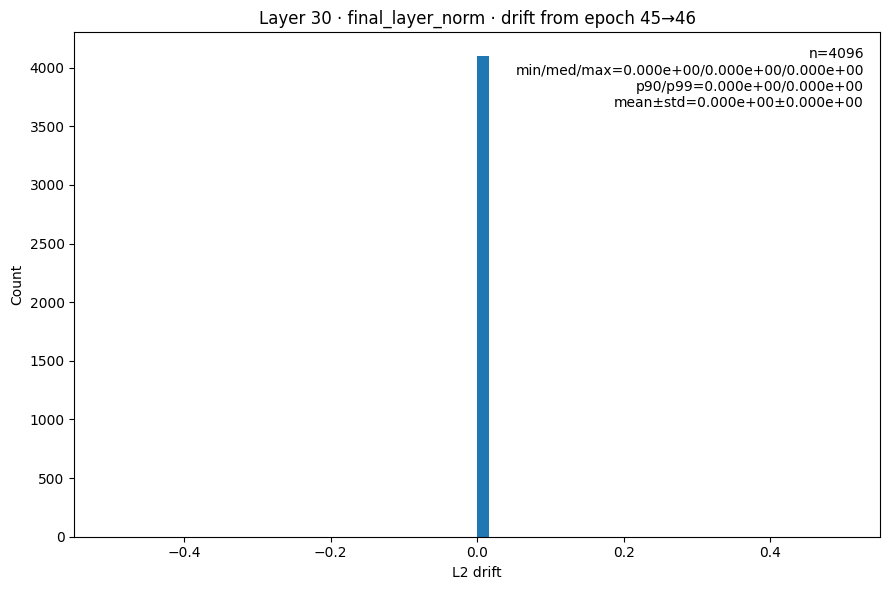

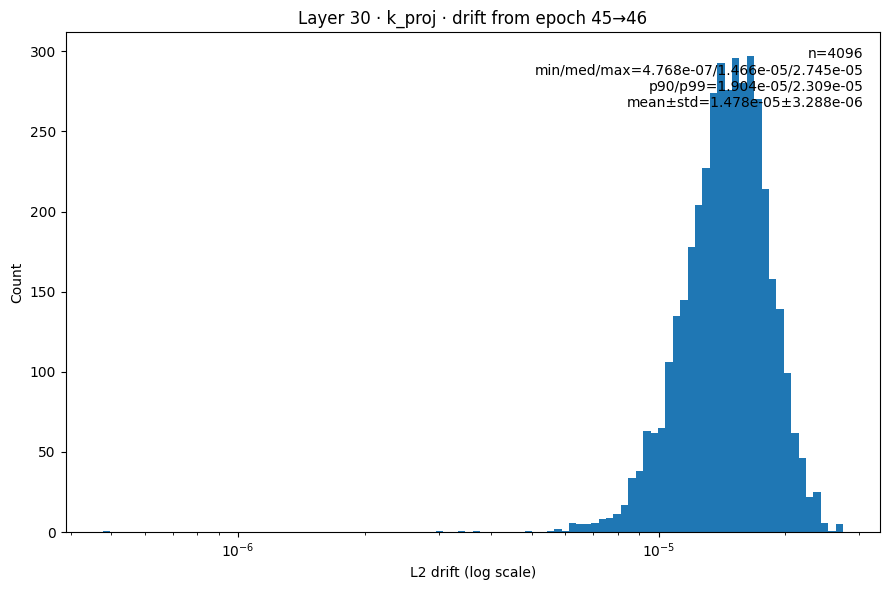

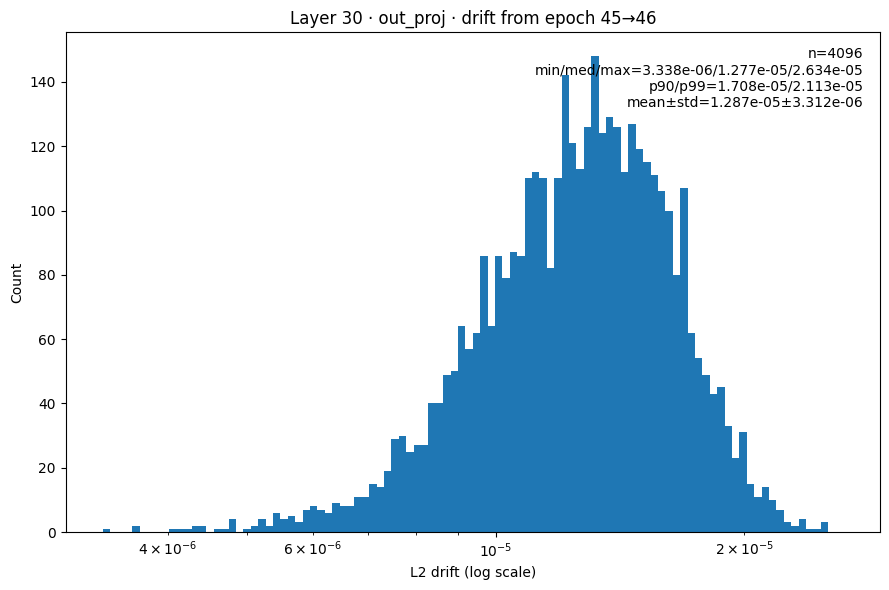

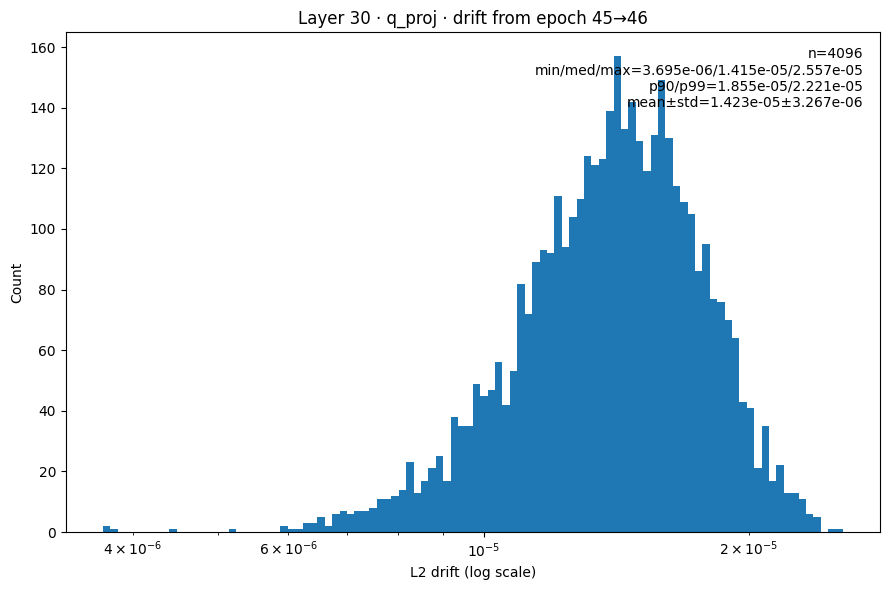

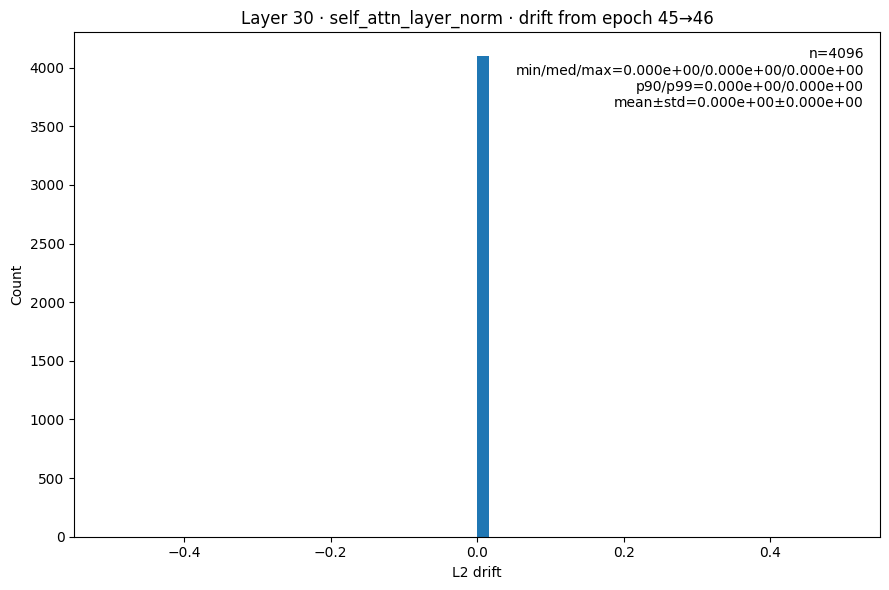

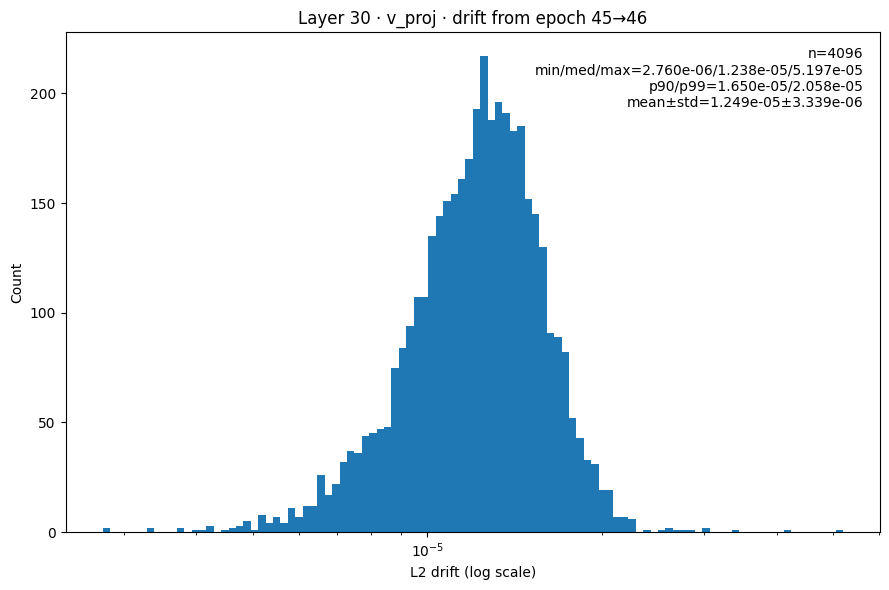

,count,min,p25,median,p75,p90,p95,p99,max,mean,std,layer,epoch_from,epoch_to
operator,,,,,,,,,,,,,,
fc1,4096,1.506165e-05,0.000023,0.000025,0.000027,0.000029,0.000031,0.000033,0.000044,0.000025,0.000003,30,45,46
fc2,16384,0.000000e+00,0.000009,0.000012,0.000014,0.000016,0.000017,0.000020,0.000029,0.000012,0.000003,30,45,46
final_layer_norm,4096,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30,45,46
k_proj,4096,4.768372e-07,0.000013,0.000015,0.000017,0.000019,0.000020,0.000023,0.000027,0.000015,0.000003,30,45,46
out_proj,4096,3.337860e-06,0.000011,0.000013,0.000015,0.000017,0.000019,0.000021,0.000026,0.000013,0.000003,30,45,46
q_proj,4096,3.695278e-06,0.000012,0.000014,0.000016,0.000019,0.000020,0.000022,0.000026,0.000014,0.000003,30,45,46
self_attn_layer_norm,4096,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30,45,46
v_proj,4096,2.759895e-06,0.000010,0.000012,0.000014,0.000016,0.000018,0.000021,0.000052,0.000012,0.000003,30,45,46


In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def summarize(x: np.ndarray) -> dict:
    x = x[np.isfinite(x)]
    if x.size == 0:
        return {"count": 0, "min": np.nan, "p25": np.nan, "median": np.nan, "p75": np.nan,
                "p90": np.nan, "p95": np.nan, "p99": np.nan, "max": np.nan, "mean": np.nan, "std": np.nan}
    q = np.percentile(x, [0, 25, 50, 75, 90, 95, 99, 100])
    return {
        "count": int(x.size),
        "min": float(q[0]),
        "p25": float(q[1]),
        "median": float(q[2]),
        "p75": float(q[3]),
        "p90": float(q[4]),
        "p95": float(q[5]),
        "p99": float(q[6]),
        "max": float(q[7]),
        "mean": float(x.mean()),
        "std": float(x.std(ddof=0)),
    }

def freedman_diaconis_bins(x: np.ndarray, max_bins: int = 200) -> int:
    """Automatic linear bins; robust to outliers."""
    x = x[np.isfinite(x)]
    n = x.size
    if n <= 1:
        return 1
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    if iqr <= 0:
        return min(int(np.sqrt(n)), max_bins)
    bw = 2 * iqr / np.cbrt(n)
    if bw <= 0:
        return min(int(np.sqrt(n)), max_bins)
    num = int(np.ceil((x.max() - x.min()) / bw))
    return max(1, min(num, max_bins))


def plot_drift_distributions_nb(
    drift_csv: str | os.PathLike,
    layer: int,
    epoch: int,
    outdir: str | os.PathLike | None = None,
    ops: list[str] | None = None,
    logx: bool = True,
    max_bins: int = 200,
    return_stats: bool = True,
    show_figs: bool = True,
    save_figs: bool = True,
) -> pd.DataFrame | None:
    """
    For a given layer and epoch e, plot (one figure per operator) the distribution of
    per-column L2 drift from epoch e -> e+1. Optionally save figures and return stats.

    Parameters
    ----------
    drift_csv : path to CSV from epoch_pairwise_drift.py
    layer     : layer index (0-based)
    epoch     : e (we use rows with epoch_from == e)
    outdir    : where to save figures (created if missing); ignored if save_figs=False
    ops       : optional list of operator names to include; default = all present for this layer/epoch
    logx      : if True, try log-scaled histogram (uses log-spaced bins on positive values)
    max_bins  : cap on bin count (linear or log)
    return_stats : if True, return a DataFrame of summary stats
    show_figs    : if True, display figures inline
    save_figs    : if True, save each figure as PNG in outdir

    Returns
    -------
    stats_df or None
    """
    df = pd.read_csv(drift_csv)
    df = df[(df["layer"] == layer) & (df["epoch_from"] == epoch)].copy()
    if df.empty:
        raise ValueError(f"No rows for layer={layer}, epoch_from={epoch} in {drift_csv}")

    if ops is not None:
        df = df[df["operator"].isin(ops)].copy()
        if df.empty:
            raise ValueError("After filtering by ops, no data remains.")
        op_list = ops
    else:
        op_list = sorted(df["operator"].unique().tolist())

    if save_figs:
        if outdir is None:
            raise ValueError("outdir must be provided if save_figs=True")
        Path(outdir).mkdir(parents=True, exist_ok=True)

    stats_rows = []

    for op in op_list:
        df_op = df[df["operator"] == op]
        if df_op.empty:
            continue

        x = df_op["l2_abs_change"].to_numpy(dtype=np.float64)
        stats = summarize(x)
        stats.update({
            "operator": op,
            "layer": layer,
            "epoch_from": epoch,
            "epoch_to": epoch + 1,
        })
        stats_rows.append(stats)

        # Choose bins
        use_log = False
        if logx:
            x_pos = x[x > 0]
            if x_pos.size > 0:
                lo, hi = float(x_pos.min()), float(x_pos.max())
                if hi > lo:
                    n_bins = min(100, max_bins)
                    bins = np.logspace(np.log10(lo), np.log10(hi), num=n_bins + 1)
                    use_log = True
                else:
                    bins = freedman_diaconis_bins(x_pos, max_bins)
            else:
                bins = freedman_diaconis_bins(x, max_bins)
        else:
            bins = freedman_diaconis_bins(x, max_bins)

        # Plot (one figure per operator)
        fig = plt.figure(figsize=(9, 6))
        ax = plt.gca()

        if use_log:
            # Only positive values plotted on log axis
            ax.hist(x[x > 0], bins=bins, edgecolor=None)
            ax.set_xscale("log")
            ax.set_xlabel("L2 drift (log scale)")
        else:
            ax.hist(x, bins=bins, edgecolor=None)
            ax.set_xlabel("L2 drift")

        ax.set_ylabel("Count")
        ax.set_title(f"Layer {layer} · {op} · drift from epoch {epoch}→{epoch+1}")

        # Annotate with key stats
        if stats["count"] > 0:
            txt = (f"n={stats['count']}\n"
                   f"min/med/max={stats['min']:.3e}/{stats['median']:.3e}/{stats['max']:.3e}\n"
                   f"p90/p99={stats['p90']:.3e}/{stats['p99']:.3e}\n"
                   f"mean±std={stats['mean']:.3e}±{stats['std']:.3e}")
            ax.text(0.98, 0.97, txt, transform=ax.transAxes, ha="right", va="top")

        plt.tight_layout()

        if save_figs:
            out_path = Path(outdir) / f"hist_layer{layer}_{op}_e{epoch}_to_{epoch+1}.png"
            plt.savefig(out_path, dpi=150)

        if show_figs:
            plt.show()
        else:
            plt.close(fig)

    if return_stats and stats_rows:
        return pd.DataFrame(stats_rows).set_index("operator").sort_index()
    return None


# Inputs
epoch     = 45   # visualize e -> e+1
layer     = 30
drift_csv = f"./output/neuron_diff_raw/layer-{layer}.csv"   # from epoch_pairwise_drift.py                             
# outdir    = "/pscratch/sd/l/lsx/plots/l10_dists_e17"

# Optional: restrict to attention ops only
# ops = ["q_proj","k_proj","v_proj","out_proj"]
ops = None  # None = all operators for this layer/epoch

stats_df = plot_drift_distributions_nb(
    drift_csv=drift_csv,
    layer=layer,
    epoch=epoch,
    outdir=None,
    ops=ops,
    logx=True,          # try True first; set False for linear
    max_bins=200,
    return_stats=True,
    show_figs=True,
    save_figs=False,
)

stats_df



# CDF

/tmp/ipykernel_1119653/1497689831.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(cum, x)             # area under Lorenz curve


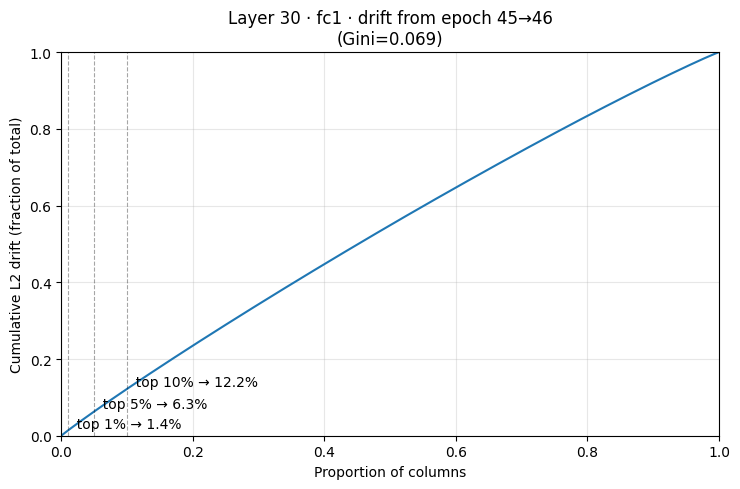

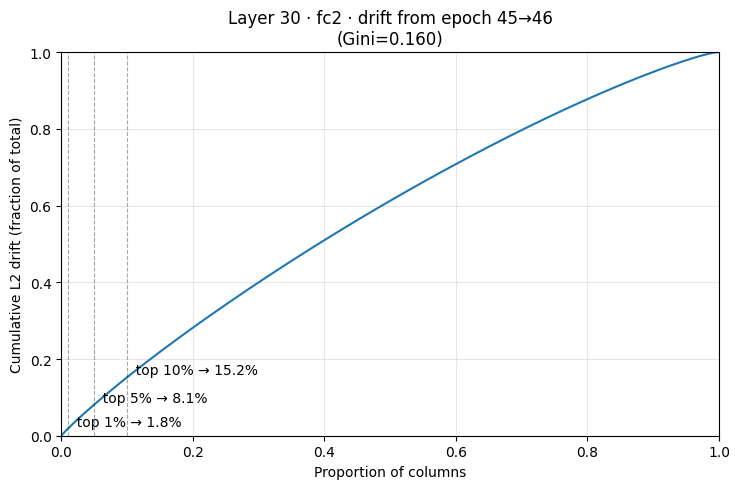

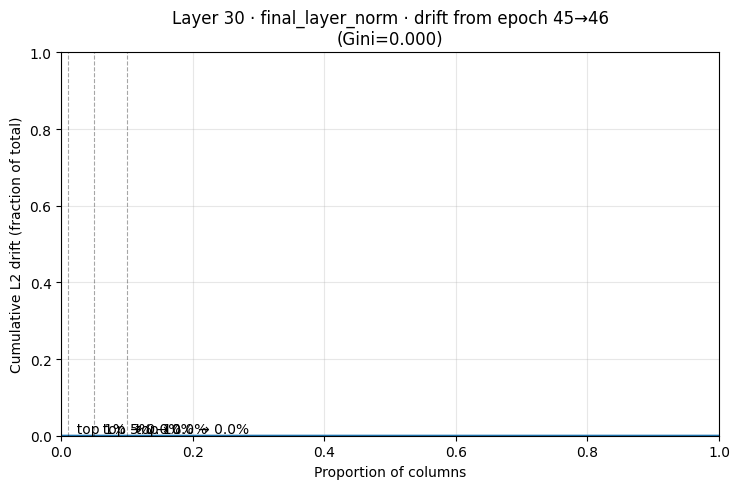

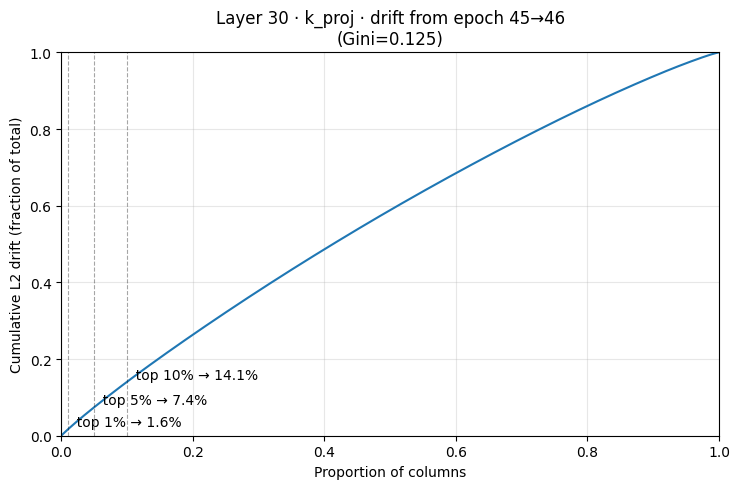

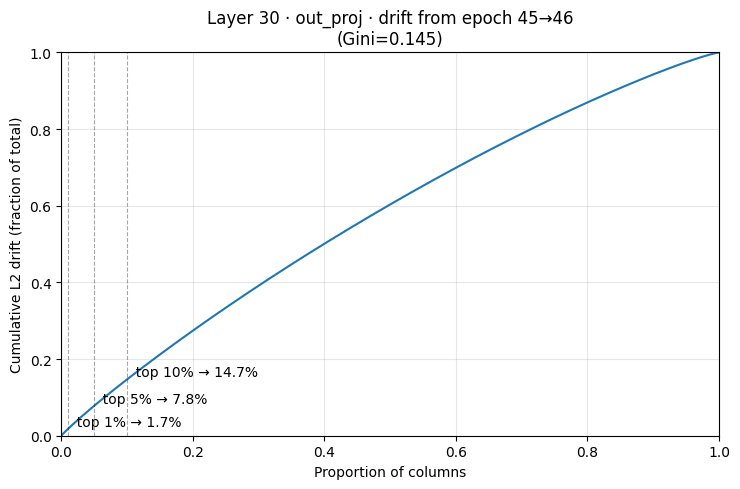

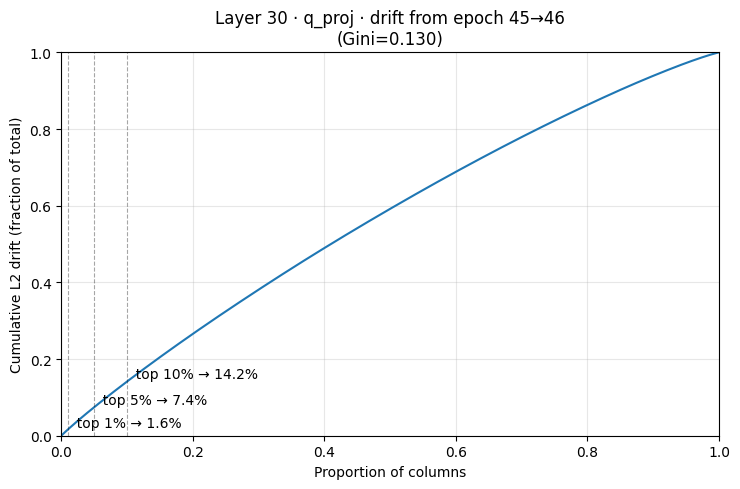

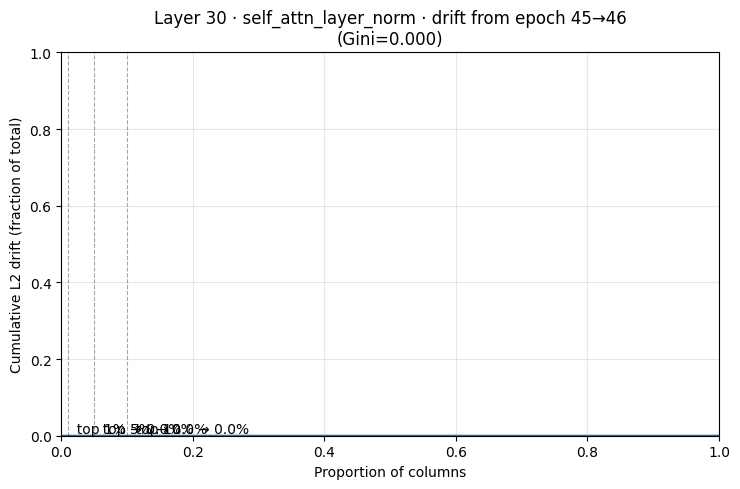

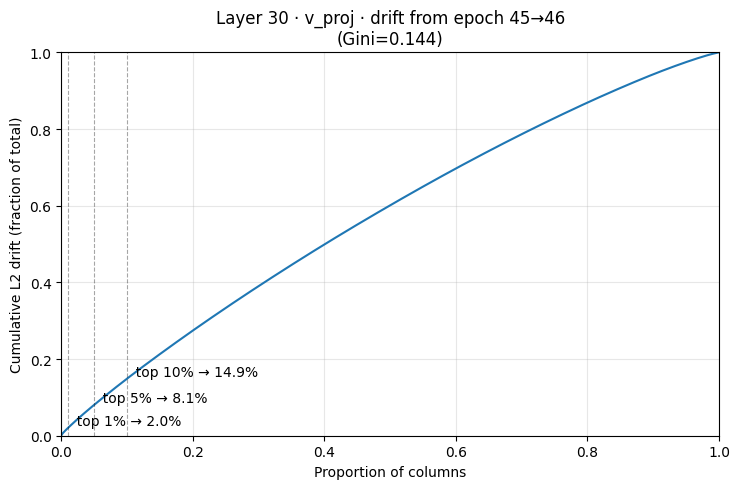

,layer,epoch_from,epoch_to,operator,top_pct,share,gini,num_columns
0,30,45,46,fc1,1,0.013529,0.069067,4096
1,30,45,46,fc1,5,0.063191,0.069067,4096
2,30,45,46,fc1,10,0.122245,0.069067,4096
3,30,45,46,fc2,1,0.018303,0.159922,16384
4,30,45,46,fc2,5,0.081228,0.159922,16384
5,30,45,46,fc2,10,0.152337,0.159922,16384
6,30,45,46,final_layer_norm,1,0.000000,0.000000,4096
7,30,45,46,final_layer_norm,5,0.000000,0.000000,4096
8,30,45,46,final_layer_norm,10,0.000000,0.000000,4096
9,30,45,46,k_proj,1,0.016482,0.125099,4096


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def topshare_curve(values: np.ndarray):
    """Return x (proportion of columns) and y (cumulative share) sorted DESC by value."""
    v = np.asarray(values, dtype=np.float64)
    v = v[np.isfinite(v)]
    if v.size == 0:
        return np.array([0.0, 1.0]), np.array([0.0, 1.0])
    v = np.sort(v)[::-1]                # DESC so left side = top columns
    c = np.cumsum(v)
    total = c[-1]
    if total <= 0:
        # all zeros
        x = np.linspace(0, 1, v.size, endpoint=True)
        y = np.zeros_like(x)
        return x, y
    y = c / total
    x = np.arange(1, v.size + 1) / v.size
    return x, y

def gini_from_values(values: np.ndarray):
    """Optional: Gini coefficient (0=uniform, 1=all mass in one column)."""
    v = np.asarray(values, dtype=np.float64)
    v = v[np.isfinite(v)]
    n = v.size
    if n == 0:
        return np.nan
    if np.allclose(v, 0):
        return 0.0
    v = np.sort(v)                      # ASC for Lorenz
    cum = np.cumsum(v) / v.sum()
    x = np.arange(1, n+1) / n
    area = np.trapz(cum, x)             # area under Lorenz curve
    gini = 1 - 2*area
    return float(gini)

def plot_cum_drift_topshare(
    drift_csv: str,
    layer: int,
    epoch: int,
    ops: list[str] | None = None,
    outdir: str | None = None,
    show_figs: bool = True,
    save_figs: bool = False,
    marks_pct: list[float] = [1, 5, 10],   # annotate shares at these top-% cutoffs
):
    df = pd.read_csv(drift_csv)
    # restrict to chosen layer and epoch pair e -> e+1
    df = df[(df["layer"] == layer) & (df["epoch_from"] == epoch)].copy()
    if df.empty:
        raise ValueError(f"No rows for layer={layer}, epoch_from={epoch} in {drift_csv}")

    if ops is None:
        ops = sorted(df["operator"].unique().tolist())
    else:
        df = df[df["operator"].isin(ops)]
        if df.empty:
            raise ValueError("After filtering by ops, no data remains.")

    if save_figs and outdir is None:
        raise ValueError("Provide outdir when save_figs=True")
    if save_figs:
        Path(outdir).mkdir(parents=True, exist_ok=True)

    results = []  # optional: collect top-% shares & gini

    for op in ops:
        dfo = df[df["operator"] == op]
        vals = dfo["l2_abs_change"].to_numpy(dtype=np.float64)

        x, y = topshare_curve(vals)
        gini = gini_from_values(vals)

        # figure (one per operator)
        fig = plt.figure(figsize=(7.5, 5.0))
        ax = plt.gca()
        ax.plot(x, y)                           # default style; no seaborn
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel("Proportion of columns")
        ax.set_ylabel("Cumulative L2 drift (fraction of total)")
        ax.set_title(f"Layer {layer} · {op} · drift from epoch {epoch}→{epoch+1}\n(Gini={gini:.3f})")

        # annotate top-% shares (e.g., 1%, 5%, 10%)
        n = len(x)
        if n > 0 and np.isfinite(y).any():
            for p in marks_pct:
                k = max(1, int(np.ceil(p / 100.0 * n)))
                share = y[k-1]                  # since y is cumulative of DESC-sorted
                ax.axvline(k / n, ls="--", lw=0.8, color="k", alpha=0.35)
                ax.text(k / n, share, f"  top {p:.0f}% → {share*100:.1f}%", va="bottom")

                results.append({
                    "layer": layer, "epoch_from": epoch, "epoch_to": epoch+1,
                    "operator": op, "top_pct": p, "share": float(share), "gini": gini,
                    "num_columns": int(n)
                })

        plt.tight_layout()
        if save_figs:
            out_path = Path(outdir) / f"topshare_layer{layer}_{op}_e{epoch}_to_{epoch+1}.png"
            plt.savefig(out_path, dpi=150)
        if show_figs:
            plt.show()
        else:
            plt.close(fig)

    return pd.DataFrame(results) if results else None

layer = 30
drift_csv = f"./output/neuron_diff_raw/layer-{layer}.csv"
epoch = 45
ops = None  # or e.g. ["q_proj","k_proj","v_proj","out_proj"]

stats = plot_cum_drift_topshare(
    drift_csv=drift_csv,
    layer=layer,
    epoch=epoch,
    ops=ops,
    outdir="/pscratch/sd/l/lsx/plots/l10_topshare_e17",
    show_figs=True,
    save_figs=False,
    marks_pct=[1, 5, 10]
)
stats

